In [1]:
import json
import logging
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from train_models import create_avg_dataset
from collections import OrderedDict

%matplotlib inline

### Lee todos los conjuntos de entrenamiento

In [2]:
BASE_PATH_DATA = '/media/ivan/DDE/datasets_proyecto_mt'

In [3]:
train_data_csv_paths = ['/datasets/en_train.csv', './datasets/es_train.csv', './datasets/ar_train.csv']
train_labels_json_paths = ['./authors_labels/en_train_labels.json', './authors_labels/es_train_labels.json','./authors_labels/ar_train_labels.json']
X_dataframes = [None for i in range(len(train_data_csv_paths))]
y_dataframes = [None for i in range(len(train_labels_json_paths))]
list_of_ids = [None for i in range(len(X_dataframes))]
i = 0
t_start = time()
for path_x, path_y in zip(train_data_csv_paths, train_labels_json_paths):
    list_of_ids[i] = path_x.strip().split('/')[2][:2]
    X = pd.read_csv(BASE_PATH_DATA + path_x, sep='\s*,\s*', header=0, encoding='ascii', engine='python')
    X, y_dataframes[i] = create_avg_dataset(X, path_y)
    y_pred_dict = OrderedDict([("class", y_dataframes[i])])
    X_dataframes[i] = pd.concat([X.reset_index(drop=True), pd.DataFrame.from_dict(y_pred_dict)], axis=1)
    i += 1
print("{} seconds to read csv's and create all dataframes".format(time() - t_start))

173.43304300308228 seconds to read csv's and create all dataframes


In [4]:
def save_plot_sum(categories, freqs, filename):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig = plt.figure()
    plt.bar(categories, freqs)
    plt.xticks(np.arange(len(freqs)), categories, rotation=90, fontsize=15)
    lang, genre = filename.strip().split('_')
    languages_dict = {"EN" : "Inglés", "ES": "Español", "AR" : "Árabe"}
    genre_dict = {"f" : "Femenino" , "m" : "Masculino"}
    lang = languages_dict[lang]
    genre = genre_dict[genre]
    plt.title("Idioma: {}\nGénero: {}".format(lang, genre), fontsize=18)
    fig.savefig("./plots/" + filename + ".png", bbox_inches='tight')

In [5]:
def create_freqs_vectors(list_of_dataframes=X_dataframes, top_n=50, save_plots=False, order=True):
    authors_top_attr_sum = []
    authors_top_attr_names = []
    labels_languages = ["EN", "ES", "AR"]
    for i in range(len(X_dataframes)):
        grouped_sum_instances = X_dataframes[i].groupby('class').sum()
        females_freqs = grouped_sum_instances.loc["female", :]
        males_freqs = grouped_sum_instances.loc["male", :]
        if order == True:
            females_freqs = females_freqs.sort_values(ascending=False)
            males_freqs = males_freqs.sort_values(ascending=False)
        males_top_n_categories = males_freqs.keys()[:top_n]
        females_top_n_categories = females_freqs.keys()[:top_n]
        authors_top_attr_sum.append(males_freqs[:top_n])
        authors_top_attr_names.append(males_top_n_categories)
        authors_top_attr_sum.append(females_freqs[:top_n])
        authors_top_attr_names.append(females_top_n_categories)
        if save_plots:
            save_plot_sum(males_top_n_categories, males_freqs[:top_n], labels_languages[i] + "_m")
            save_plot_sum(females_top_n_categories, females_freqs[:top_n], labels_languages[i] + "_f")
    return authors_top_attr_sum, authors_top_attr_names

In [32]:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(0,10))


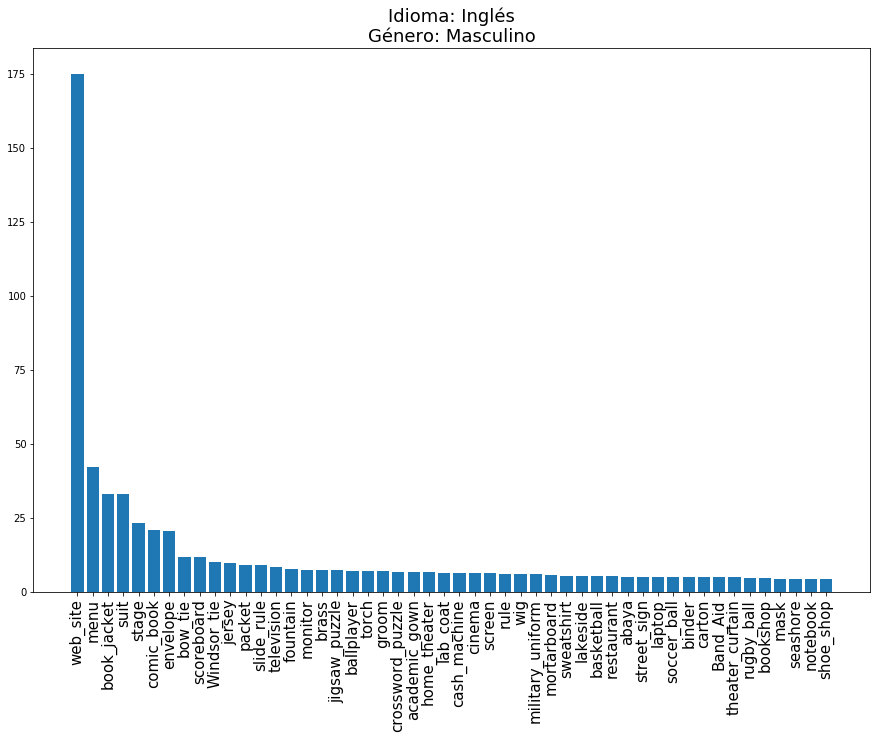

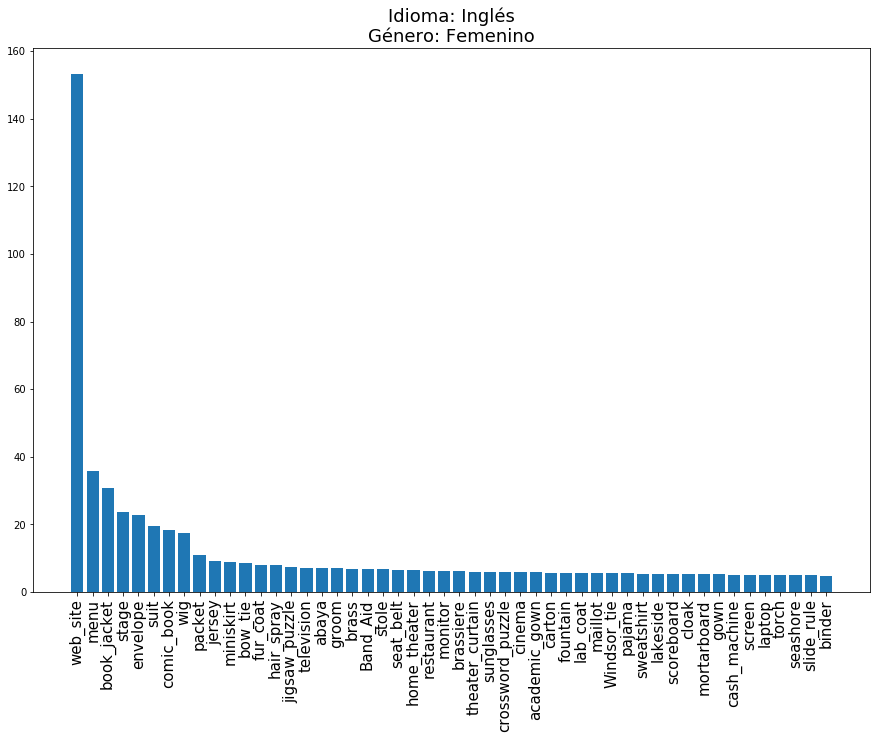

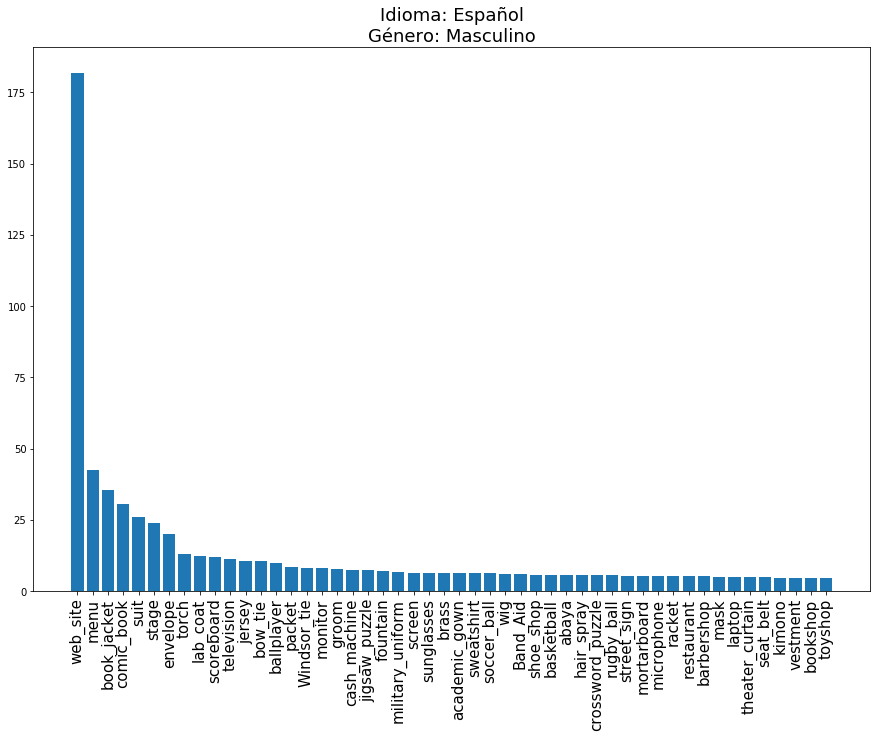

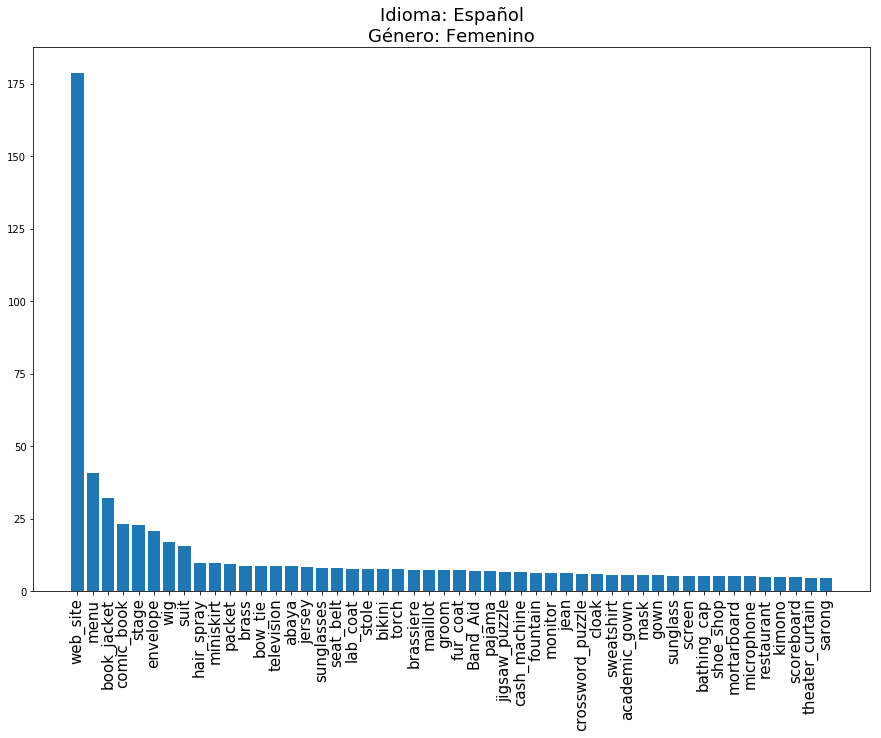

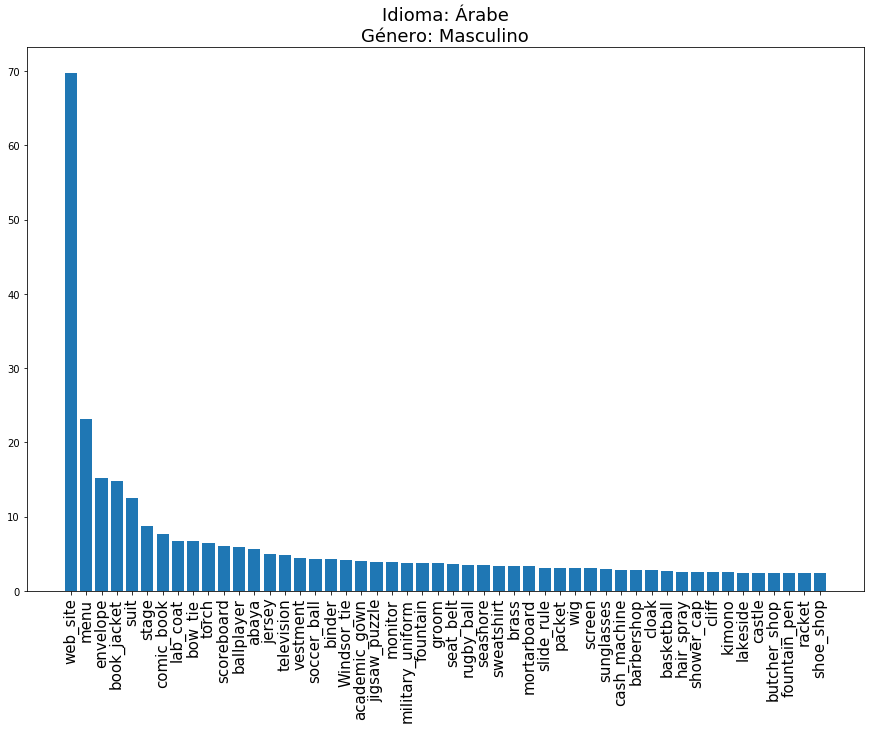

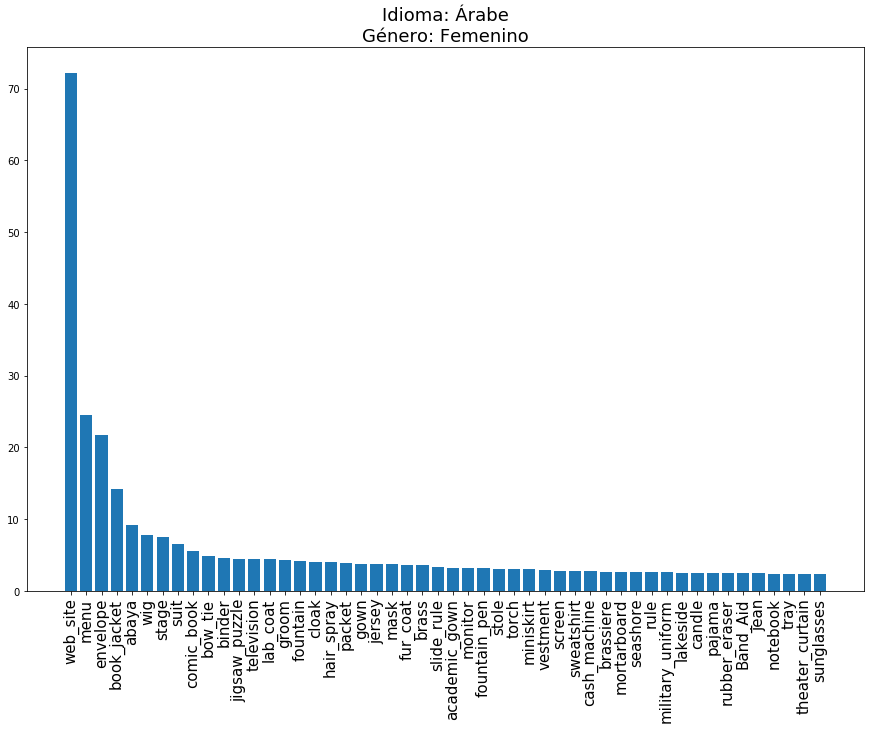

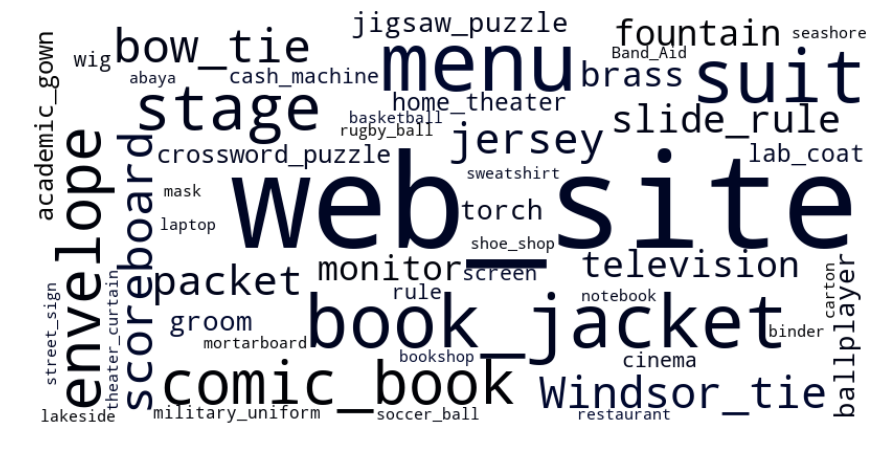

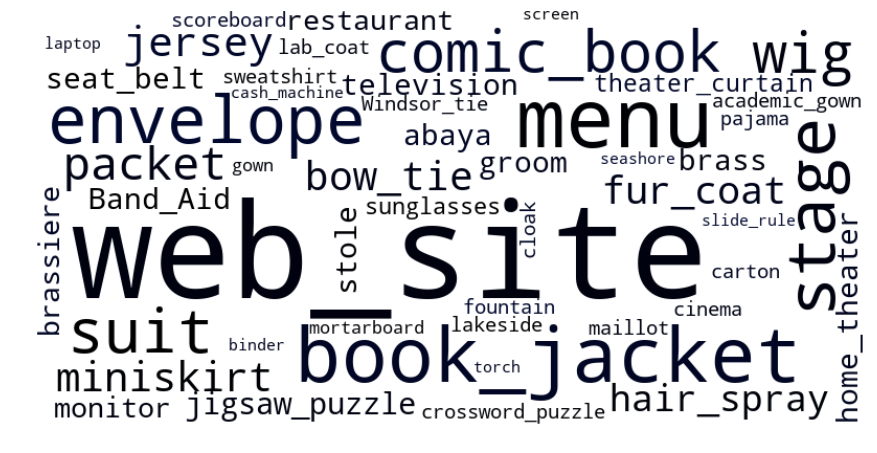

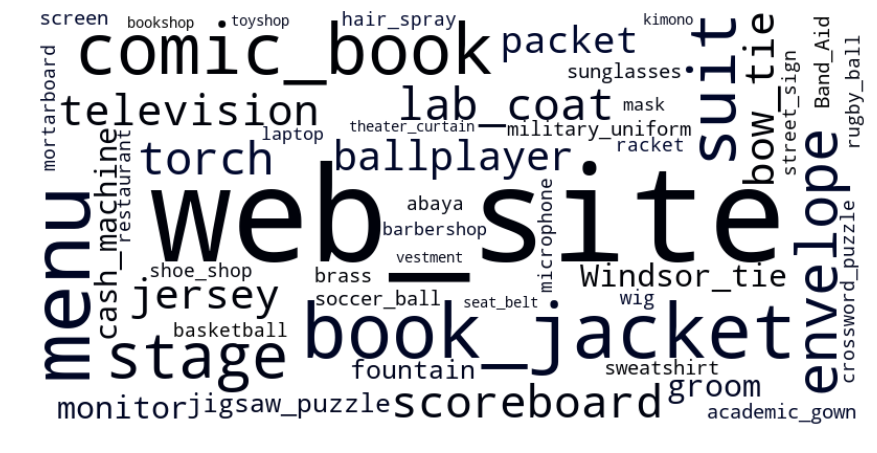

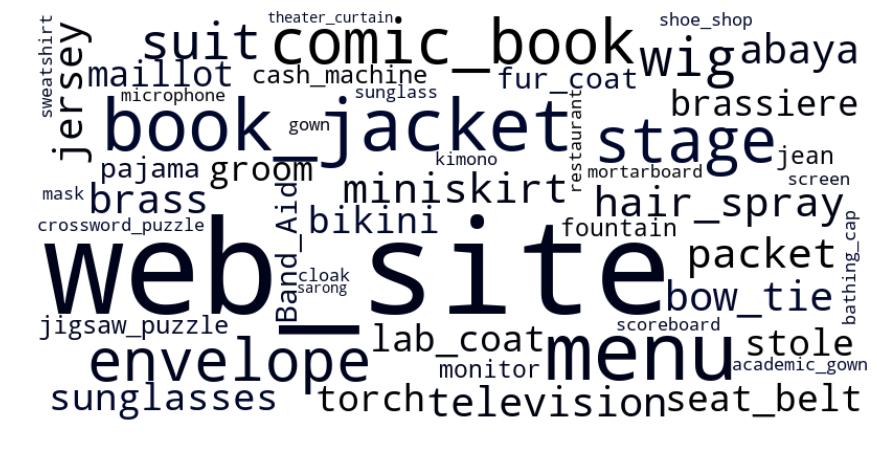

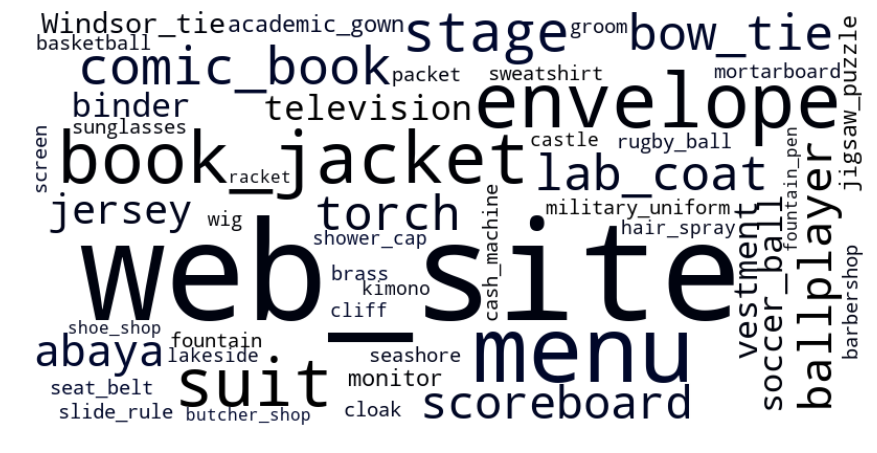

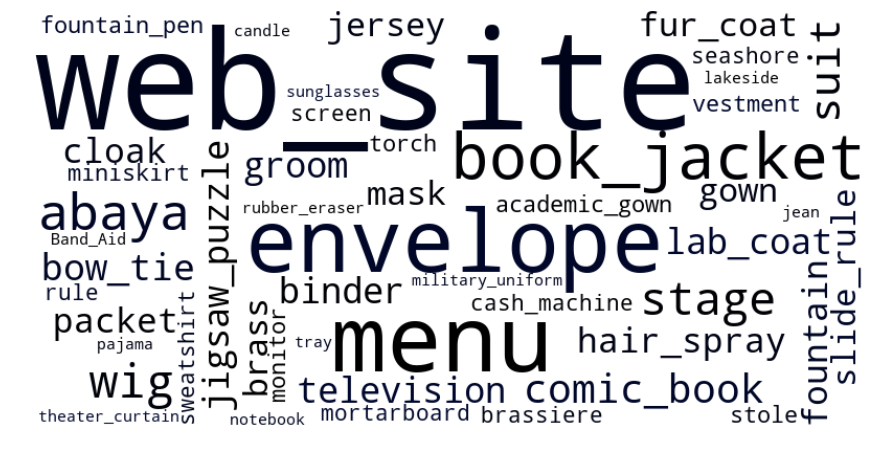

In [33]:
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=50, save_plots=True)
plt.rcParams['figure.figsize'] = [15, 10]
languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
sex = ["M", "F", "M", "F", "M", "F"]
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color="white")
i = 0
for authors_sum in authors_top_attr_sum:
    wordcloud.generate_from_frequencies(frequencies=authors_sum)
    plt.figure()
    
    plt.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("./plots/{}_{}_wordcloud.png".format(languages[i], sex[i]))
    i += 1

In [16]:
labels_languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
correlation_vars = []
vars_order = []
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=100)
for i in range(len(authors_top_attr_sum) - 1):
    for j in range(i + 1, len(authors_top_attr_sum)):
        language_a = labels_languages[i]
        genre_a = "M" if i % 2 == 0 else "F"
        language_b = labels_languages[j]
        genre_b = "M" if j % 2 == 0 else "F"
        print("Comparando género {} en idioma {} con género {} en idioma {}".format(genre_a, language_a, genre_b, language_b))
        intersection = set(authors_top_attr_names[i]).intersection(set(authors_top_attr_names[j]))
        union = set(authors_top_attr_names[i]).union(set(authors_top_attr_names[j]))
        print("Intersección {}".format(len(intersection)))
        a = np.array(authors_top_attr_sum[i][list(intersection)])
        b = np.array(authors_top_attr_sum[j][list(intersection)])
        correlation_vars.append(a)
        correlation_vars.append(b)
        vars_order.append("{}_{}".format(genre_a, language_a))
        vars_order.append("{}_{}".format(genre_b, language_b))
#         print(authors_top_attr_sum[i][intersection_list])
#         print(authors_top_attr_sum[j][intersection_list])
#         print("Coeficiente de correlación =  {}".format(np.corrcoef(a, b)[0,1]))
        print("Coeficiente de Jaccard =  {}".format(len(intersection) / len(union)))

Comparando género M en idioma EN con género F en idioma EN
Intersección 77
Coeficiente de Jaccard =  0.6260162601626016
Comparando género M en idioma EN con género M en idioma ES
Intersección 85
Coeficiente de Jaccard =  0.7391304347826086
Comparando género M en idioma EN con género F en idioma ES
Intersección 74
Coeficiente de Jaccard =  0.5873015873015873
Comparando género M en idioma EN con género M en idioma AR
Intersección 84
Coeficiente de Jaccard =  0.7241379310344828
Comparando género M en idioma EN con género F en idioma AR
Intersección 71
Coeficiente de Jaccard =  0.5503875968992248
Comparando género F en idioma EN con género M en idioma ES
Intersección 80
Coeficiente de Jaccard =  0.6666666666666666
Comparando género F en idioma EN con género F en idioma ES
Intersección 89
Coeficiente de Jaccard =  0.8018018018018018
Comparando género F en idioma EN con género M en idioma AR
Intersección 76
Coeficiente de Jaccard =  0.6129032258064516
Comparando género F en idioma EN con gén

In [6]:
from sklearn.feature_selection import mutual_info_classif
labels = labels_languages = ["EN","ES", "AR"]
info_gain = [[] for i in range(len(X_dataframes))]
for i in range(len(X_dataframes)):
    print(labels[i])
    res = dict(zip(X_dataframes[i].keys()[:-1], mutual_info_classif(X_dataframes[i].drop(["class"], axis=1), y_dataframes[i])))
    for key in sorted(res, key=res.get, reverse=True):
        info_gain[i].append((key, res[key]))

EN
ES
AR


In [50]:
from IPython.display import HTML

for i in info_gain:
    info_gain_table = """<table>
        <tr>
        <th>Atributo</th>
        <th>GI</th>
        </tr>"""
    idx = 0
    for j in i:
        if idx == 50:
            break
        idx += 1    
        if j[1] > 0:
            info_gain_table += "<tr>"
            info_gain_table += "<td>{}</td><td>{}</td>".format(j[0], j[1])
            info_gain_table += "</tr>"
        
    info_gain_table += "</table>"
    display(HTML(info_gain_table))

{'hair_spray', 'brassiere', 'stole', 'Blenheim_spaniel', 'Persian_cat', 'overskirt', 'miniskirt', 'ballplayer', 'velvet', 'lipstick', 'wig', 'bath_towel', 'Shih-Tzu', 'spatula', 'suit'}


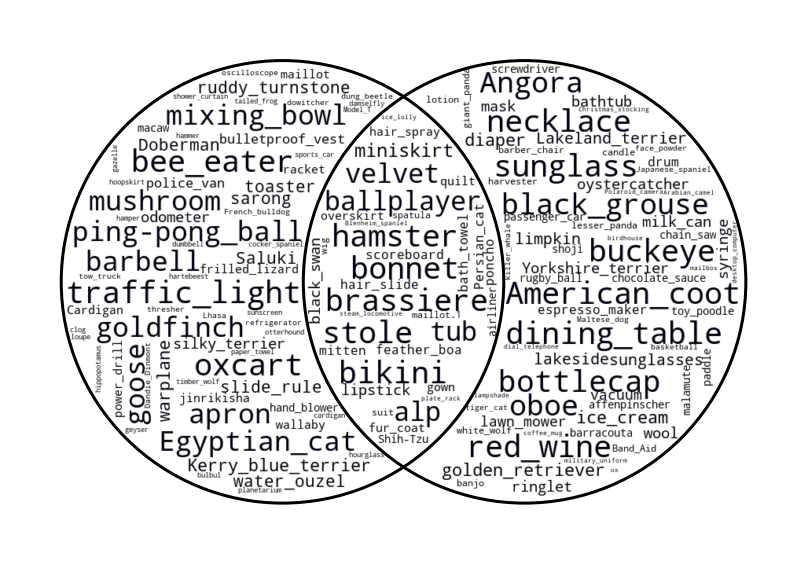

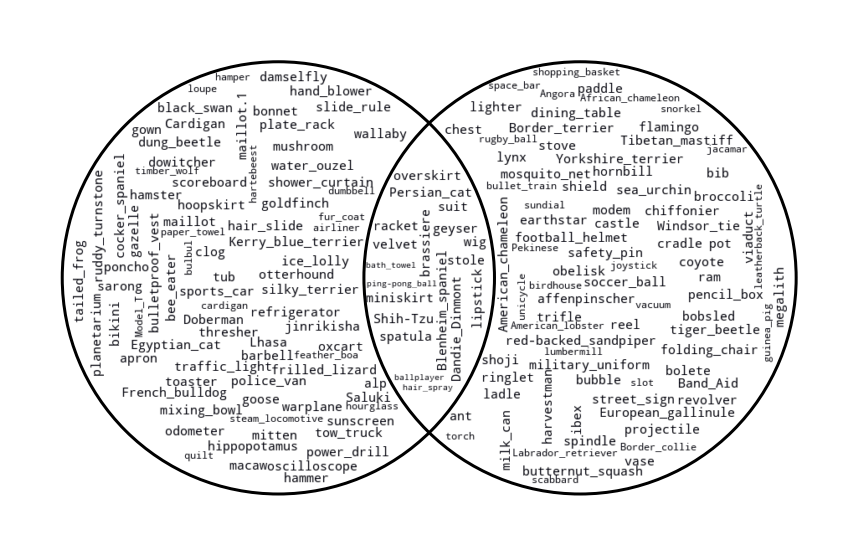

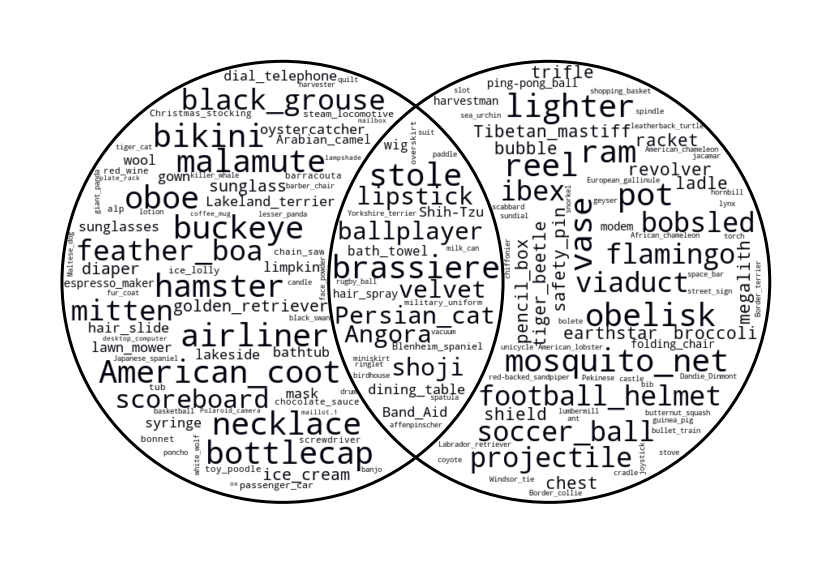

In [10]:
from matplotlib_venn_wordcloud import venn2_wordcloud
plt.rcParams['figure.figsize'] = [15, 10]
top_attr = 100
english = set([t[0] for t in info_gain[0][:top_attr]])
spanish = set([t[0] for t in info_gain[1][:top_attr]])
arab = set([t[0] for t in info_gain[2][:top_attr]])
venn2_wordcloud([english, spanish])
venn2_wordcloud([english, arab])
venn2_wordcloud([spanish, arab])
print(english.intersection(spanish).intersection(arab))

Comparando género M en idioma EN con género F en idioma EN
Intersección 1000
Comparando género M en idioma EN con género M en idioma ES
Intersección 1000
Comparando género M en idioma EN con género F en idioma ES
Intersección 1000
Comparando género M en idioma EN con género M en idioma AR
Intersección 1000
Comparando género M en idioma EN con género F en idioma AR
Intersección 1000
Comparando género F en idioma EN con género M en idioma ES
Intersección 1000
Comparando género F en idioma EN con género F en idioma ES
Intersección 1000
Comparando género F en idioma EN con género M en idioma AR
Intersección 1000
Comparando género F en idioma EN con género F en idioma AR
Intersección 1000
Comparando género M en idioma ES con género F en idioma ES
Intersección 1000
Comparando género M en idioma ES con género M en idioma AR
Intersección 1000
Comparando género M en idioma ES con género F en idioma AR
Intersección 1000
Comparando género F en idioma ES con género M en idioma AR
Intersección 1000

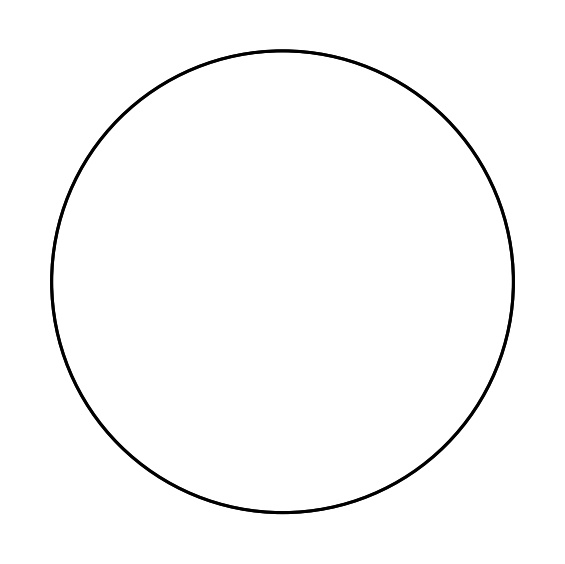

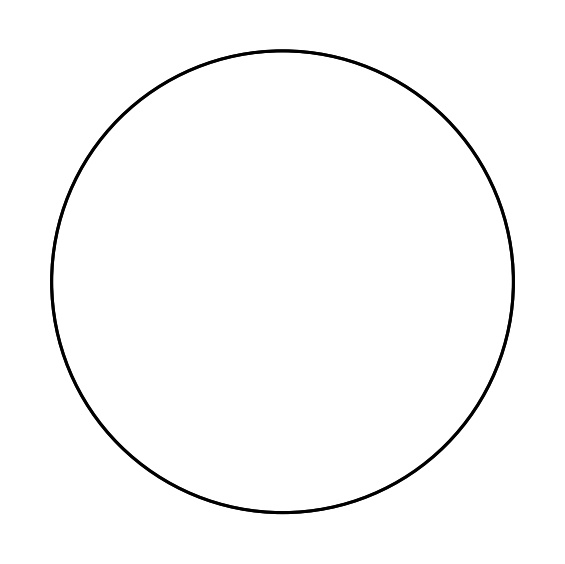

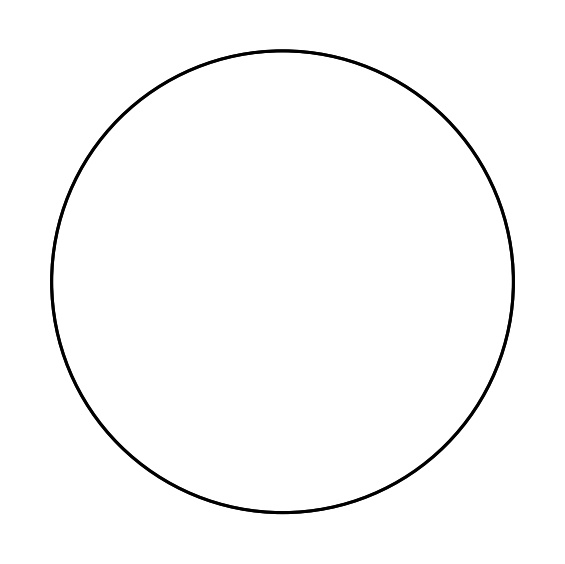

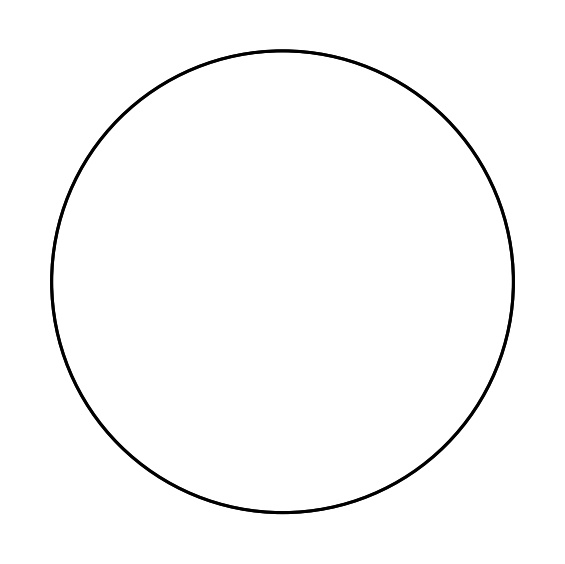

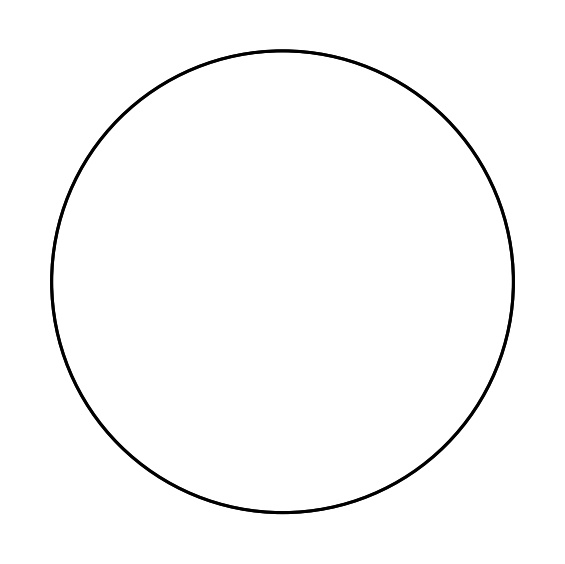

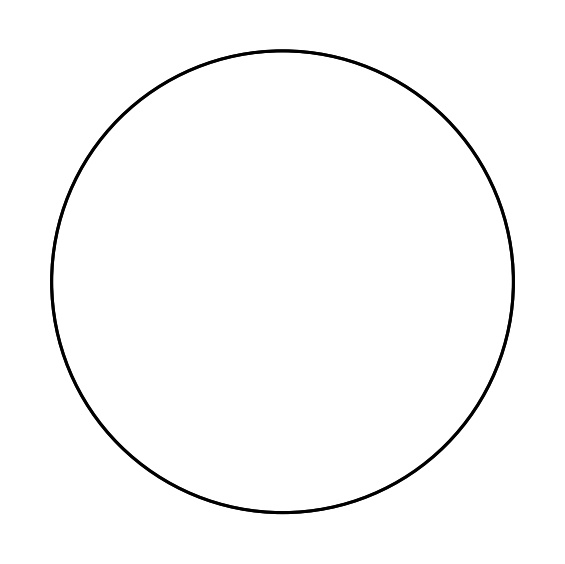

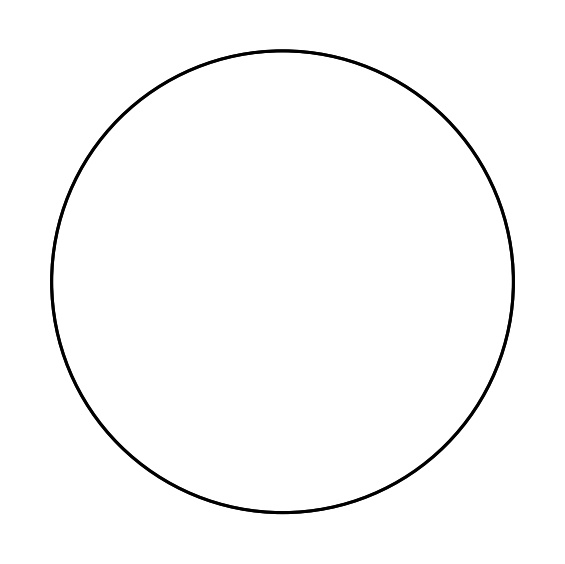

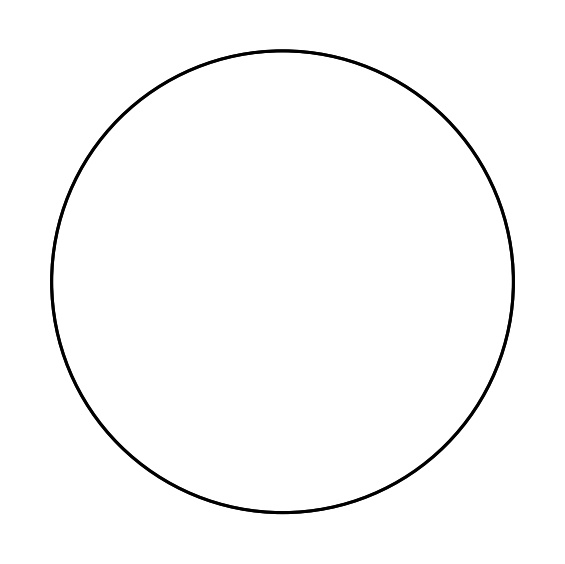

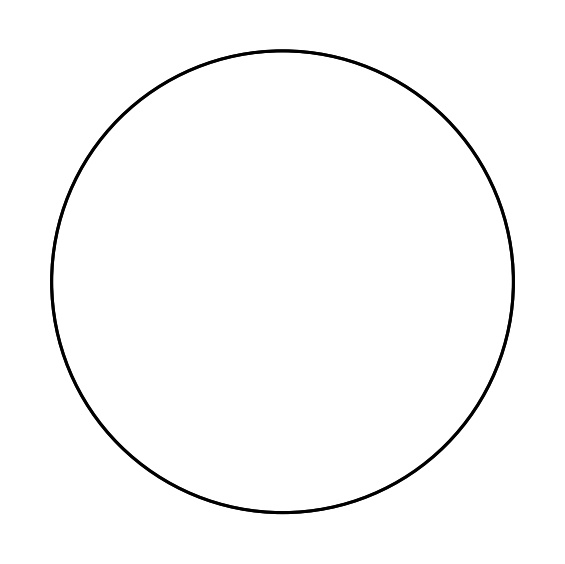

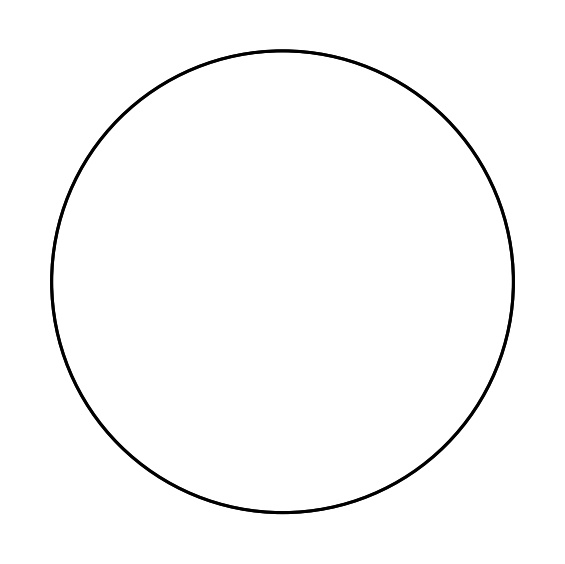

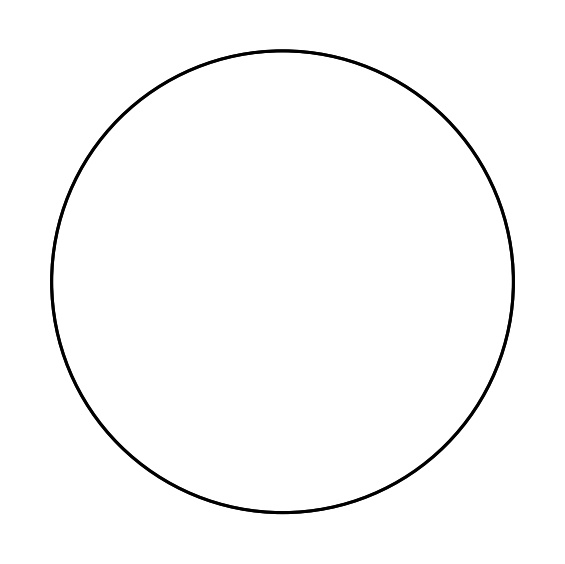

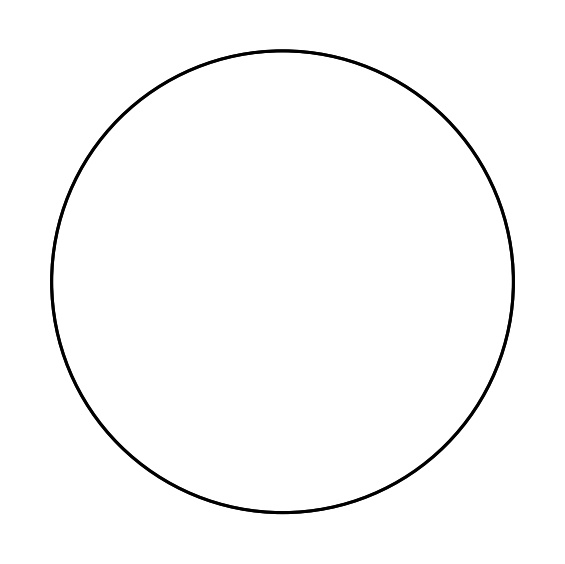

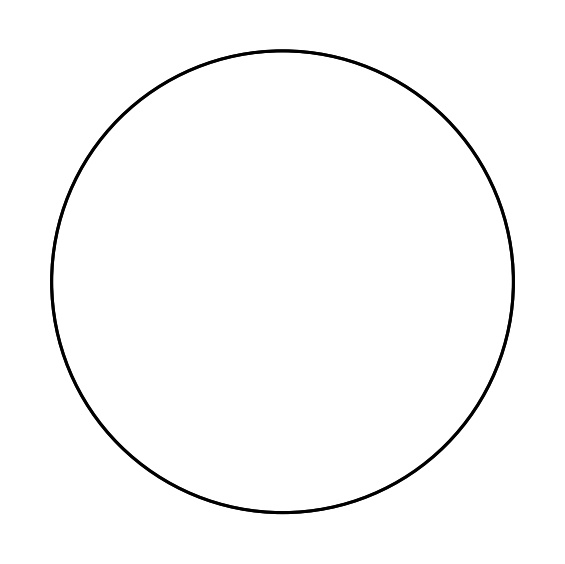

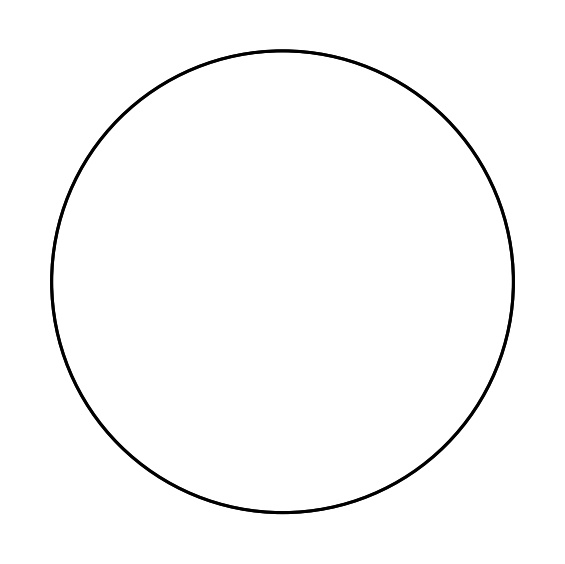

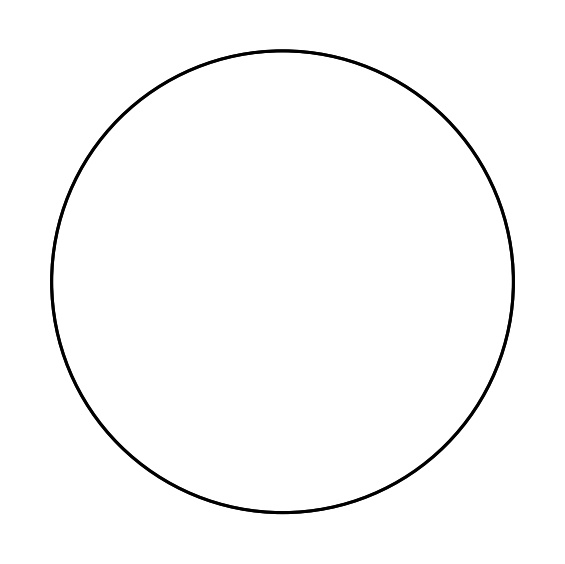

In [19]:
from matplotlib_venn_wordcloud import venn2_wordcloud
labels_languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
all_vocabulary = set()
plt.rcParams['figure.figsize'] = [15, 10]
for i in range(len(authors_top_attr_sum) - 1):
    for j in range(i + 1, len(authors_top_attr_sum)):
        language_a = labels_languages[i]
        genre_a = "M" if i % 2 == 0 else "F"
        language_b = labels_languages[j]
        genre_b = "M" if j % 2 == 0 else "F"
        print("Comparando género {} en idioma {} con género {} en idioma {}".format(genre_a, language_a, genre_b, language_b))
        print("Intersección {}".format(len(set(authors_top_attr_names[i]).intersection(set(authors_top_attr_names[j])))))
        a_categories = [c for c in authors_top_attr_names[i] if c not in authors_top_attr_names[j]]
        b_categories = [c for c in authors_top_attr_names[j] if c not in authors_top_attr_names[i]]
#         print("Atributos idioma {} género {}".format(language_a, genre_a))
#         print(a_categories)
#         print("Atributos idioma {} género {}".format(language_b, genre_b))
#         print(b_categories)
        venn2_wordcloud([set(a_categories + [" "]), set(b_categories + [" "])])